This project uses a historical dataset and apply different classification algorithm on the data. The following alogrithms are used to build the models:  

- k-Nearest Neighbour (KNN)
- Decision Tree
- Support Vector Machine (SVM)
- Logistic Regression


The following metrics are used to evaluate the accuracy of each classifier:  
- Jaccard index
- F1-score
- LogLoass

In [109]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import seaborn as sns

### Data preparation

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [71]:
data = pd.read_csv('loan_train.csv',',')

In [72]:
data.head(10)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
5,7,7,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male
6,8,8,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male
7,9,9,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male
8,10,10,PAIDOFF,300,7,9/10/2016,9/16/2016,29,college,male
9,11,11,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,High School or Below,male


In [73]:
data.shape

(346, 10)

In [74]:
data.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [75]:
# change date columns data type to datetime
data['due_date'] = pd.to_datetime(data['due_date'])
data['effective_date'] = pd.to_datetime(data['effective_date'])
data.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


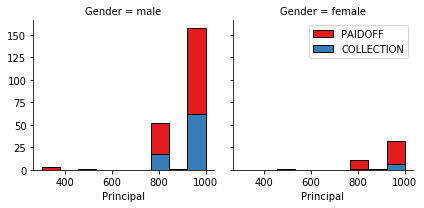

In [76]:
bins = np.linspace(data.Principal.min(), data.Principal.max(), 10)
hist = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
hist.map(plt.hist, 'Principal', bins=bins, ec="k")

hist.axes[-1].legend()
plt.show()

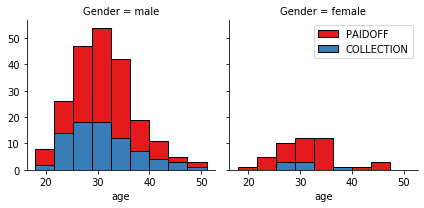

In [77]:
bins = np.linspace(data.age.min(), data.age.max(), 10)

hist = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
hist.map(plt.hist, 'age', bins=bins, ec="k")

hist.axes[-1].legend()
plt.show()

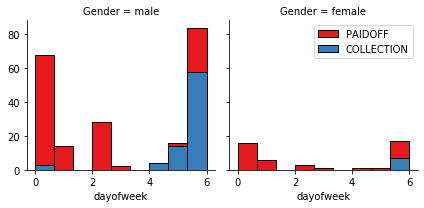

In [78]:
data['dayofweek'] = data['effective_date'].dt.dayofweek
bins = np.linspace(data.dayofweek.min(), data.dayofweek.max(), 10)
hist = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
hist.map(plt.hist, 'dayofweek', bins=bins, ec="k")
hist.axes[-1].legend()
plt.show()


from the chart it can be observed that in general people who borrow at the end of the weed tend not to pay it off. Therefore feature binarization is used to set a threshold values less then day 4.

In [79]:
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
data.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


convert categorical columns from object to category

In [80]:
data["loan_status"].unique()

array(['PAIDOFF', 'COLLECTION'], dtype=object)

In [81]:
data['education'].unique()

array(['High School or Below', 'Bechalor', 'college', 'Master or Above'],
      dtype=object)

In [82]:
data['Gender'].unique()

array(['male', 'female'], dtype=object)

In [83]:
label = LabelEncoder()
data["gender_code"] = label.fit_transform(data["Gender"])
data["education_code"] = label.fit_transform(data["education"])
data["loan_status_code"] = label.fit_transform(data["loan_status"])

In [84]:
data.dtypes

Unnamed: 0                   int64
Unnamed: 0.1                 int64
loan_status                 object
Principal                    int64
terms                        int64
effective_date      datetime64[ns]
due_date            datetime64[ns]
age                          int64
education                   object
Gender                      object
dayofweek                    int64
weekend                      int64
gender_code                  int64
education_code               int64
loan_status_code             int64
dtype: object

In [85]:
data[["Gender", "gender_code"]].head()

,Gender,gender_code
0,male,1
1,female,0
2,male,1
3,female,0
4,male,1


In [89]:
data[["education", "education_code"]].head(10)

,education,education_code
0,High School or Below,1
1,Bechalor,0
2,college,3
3,college,3
4,college,3
5,college,3
6,college,3
7,college,3
8,college,3
9,High School or Below,1


In [92]:
data[["loan_status", "loan_status_code"]].head(10)

,loan_status,loan_status_code
0,PAIDOFF,1
1,PAIDOFF,1
2,PAIDOFF,1
3,PAIDOFF,1
4,PAIDOFF,1
5,PAIDOFF,1
6,PAIDOFF,1
7,PAIDOFF,1
8,PAIDOFF,1
9,PAIDOFF,1


In [93]:
data.isnull().sum()

Unnamed: 0          0
Unnamed: 0.1        0
loan_status         0
Principal           0
terms               0
effective_date      0
due_date            0
age                 0
education           0
Gender              0
dayofweek           0
weekend             0
gender_code         0
education_code      0
loan_status_code    0
dtype: int64

In [94]:
data["education_code"].value_counts()

1    151
3    149
0     44
2      2
Name: education_code, dtype: int64

In [97]:
data=data[data["education_code"]!=2]

data["education"].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Name: education, dtype: int64

### Feature selection

In [98]:
features = ['Principal','terms','age','gender_code','education_code']

data[features].head()

,Principal,terms,age,gender_code,education_code
0,1000,30,45,1,1
1,1000,30,33,0,0
2,1000,15,27,1,3
3,1000,30,28,0,3
4,1000,30,29,1,3


In [100]:
X = data[features]
y = data['loan_status_code']

### Data normalisation

In [102]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[:10]

array([[ 0.51345952,  0.91494265,  2.37885075,  0.42199786, -0.64382454],
       [ 0.51345952,  0.91494265,  0.35995768, -2.36968028, -1.51577588],
       [ 0.51345952, -0.96447776, -0.64948885,  0.42199786,  1.10007815],
       [ 0.51345952,  0.91494265, -0.48124777, -2.36968028,  1.10007815],
       [ 0.51345952,  0.91494265, -0.31300668,  0.42199786,  1.10007815],
       [ 0.51345952,  0.91494265,  0.86468095,  0.42199786,  1.10007815],
       [ 0.51345952,  0.91494265, -0.48124777,  0.42199786,  1.10007815],
       [-1.31690394, -0.96447776, -0.81772994,  0.42199786,  1.10007815],
       [-5.89281258, -1.96683532, -0.31300668,  0.42199786,  1.10007815],
       [ 0.51345952, -0.96447776,  1.36940421,  0.42199786, -0.64382454]])

## Modelling

#### Train test split

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (275, 5) (275,)
Test set: (69, 5) (69,)


### 1. K Nearest Neighbor(KNN)

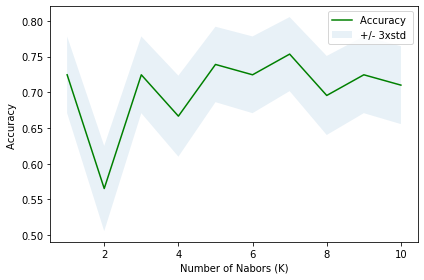

In [144]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 11
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];

for n in range(1,Ks):
    
    #Train Model and predic for each k.  
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train,y_train)
    
    predictions=knn.predict(X_test)

    mean_acc[n-1] = metrics.accuracy_score(y_test, predictions)
    
    std_acc[n-1]=np.std(predictions==y_test)/np.sqrt(predictions.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()


In [106]:
# the accuracy score is the highest among all when k = 7 

In [107]:
k = 7
#Train Model and Predict  
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)

In [108]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, predictions))

Train set Accuracy:  0.7672727272727272
Test set Accuracy:  0.7536231884057971


### 2. Decision tree

In [110]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [112]:
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print("Decision Trees Accuracy: ", metrics.accuracy_score(y_test, predTree))

Decision Trees Accuracy:  0.7246376811594203


### 3. Support Vector Machine

In [113]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [114]:
svm_pred = clf.predict(X_test)

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.74      1.00      0.85        51

    accuracy                           0.74        69
   macro avg       0.37      0.50      0.42        69
weighted avg       0.55      0.74      0.63        69

Confusion matrix, without normalization
[[ 0 18]
 [ 0 51]]


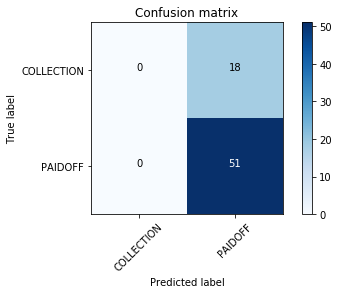

In [117]:
cnf_matrix = confusion_matrix(y_test, svm_pred)
np.set_printoptions(precision=2)

print (classification_report(y_test, svm_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

In [118]:
from sklearn.metrics import f1_score
f1_score(y_test, svm_pred, average='weighted') 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6282608695652174

In [120]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, svm_pred)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7391304347826086

### 4. Logistic regression

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [123]:
lr = LogisticRegression(C=0.01, solver='liblinear')
lr.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [124]:
logit_pred = lr.predict(X_test)
logit_prob = lr.predict_proba(X_test)

In [125]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, logit_pred)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7391304347826086

Confusion matrix, without normalization
[[ 0 18]
 [ 0 51]]


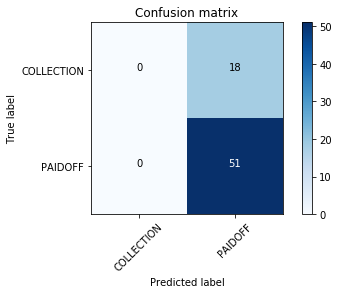

In [126]:
cnf_matrix = confusion_matrix(y_test, logit_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

In [127]:
print (classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.74      1.00      0.85        51

    accuracy                           0.74        69
   macro avg       0.37      0.50      0.42        69
weighted avg       0.55      0.74      0.63        69



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [128]:
from sklearn.metrics import log_loss
log_loss(y_test, logit_prob)

0.6067496291506826

## Model evaluation using test set

In [130]:
#load test set
test_data = pd.read_csv('loan_test.csv')
test_data.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [131]:
test_data['due_date'] = pd.to_datetime(test_data['due_date'])
test_data['effective_date'] = pd.to_datetime(test_data['effective_date'])
test_data.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [133]:
test_data['dayofweek'] = test_data['effective_date'].dt.dayofweek
test_data['weekend'] = test_data['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_data.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [134]:
label = LabelEncoder()
test_data["gender_code"] = label.fit_transform(test_data["Gender"])
test_data["education_code"] = label.fit_transform(test_data["education"])
test_data["loan_status_code"] = label.fit_transform(test_data["loan_status"])

In [135]:
test_data["education_code"].value_counts()

3    23
1    21
0     8
2     2
Name: education_code, dtype: int64

In [136]:
test_data=test_data[test_data["education_code"]!=2]

test_data["education"].value_counts()

college                 23
High School or Below    21
Bechalor                 8
Name: education, dtype: int64

### Feature selection

In [137]:
features = ['Principal','terms','age','gender_code','education_code']

test_data[features].head()

,Principal,terms,age,gender_code,education_code
0,1000,30,50,0,0
2,1000,30,43,0,1
3,1000,30,26,1,3
4,800,15,29,1,0
5,700,15,33,1,1


In [146]:
X = test_data[features]
y = test_data['loan_status_code']

### Data normalisation

In [147]:
X= preprocessing.StandardScaler().fit(X).transform(X)

### Comparison of models

In [148]:
yprob = lr.predict_proba(X)

### Evaluation

### 1. KNN

In [152]:
KNN=knn.predict(X)
a=f1_score(y, KNN, average='weighted') 
b=jaccard_similarity_score(y,KNN)
s1=pd.Series(['KNN',a, b,0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


### 2. Decision tree

In [153]:
Decisiontree=loanTree.predict(X)
a=f1_score(y, Decisiontree, average='weighted') 
b=jaccard_similarity_score(y,Decisiontree)
s2=pd.Series(['Decision Tree',a, b,0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


### 3. Support Vector Machine

In [154]:
svm=clf.predict(X)
a=f1_score(y, svm, average='weighted') 
b=jaccard_similarity_score(y,svm)
s3=pd.Series(['SVM',a, b,0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


### 4. Logistic regression

In [160]:
logistic=lr.predict(X)
a=f1_score(y, logistic, average='weighted') 
b=jaccard_similarity_score(y,logistic)
c=log_loss(y, yprob)

s4=pd.Series(['Logistic Reg',a, b,c])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## Evaluation report

In [165]:
ev_col = ['Model','F1 Score','Jaccard Score','Log Loss']

In [166]:
evaluation = pd.concat([s1,s2,s3,s4],axis=1).T
evaluation.columns=ev_col

In [167]:
evaluation

,Model,F1 Score,Jaccard Score,Log Loss
0,KNN,0.607606,0.711538,0
1,Decision Tree,0.607606,0.711538,0
2,SVM,0.617094,0.730769,0
3,Logistic Reg,0.617094,0.730769,0.616891
